In [9]:
import sys
import pandas as pd
import numpy as np

sys.path.insert(1, '../')



from tsad.base.pipeline import Pipeline
from tsad.base.datasets import load_skab
from tsad.base.wrappers import SklearnWrapper


from tsad.tasks.eda import HighLevelDatasetAnalysisTask, TimeDiscretizationTask
from tsad.tasks.eda import FindNaNTask, EquipmentDowntimeTask
from tsad.tasks.preprocess import ScalingTask, ValueRangeProcessingTask, ResampleProcessingTask 
from tsad.tasks.preprocess import FeatureProcessingTask, SplitByNaNTask, PrepareSeqSamplesTask
from tsad.tasks.deep_learning_anomaly_detection import ResidualAnomalyDetectionTask
from tsad.tasks.deep_learning_forecasting import DeepLeaningTimeSeriesForecastingTask




In [12]:
from sklearn.preprocessing import StandardScaler
StandardScalerTask = SklearnWrapper(StandardScaler)

In [2]:
dataset = load_skab()
columns = dataset.feature_names
targets = dataset.target_names
df = dataset.frame

In [3]:
df.index.levels[0]

Index(['air/0', 'air/1', 'fluid/0', 'fluid/1', 'fluid/2', 'fluid/3', 'fluid/4',
       'fluid/5', 'rotor/0', 'rotor/1', 'rotor/2', 'rotor/3', 'rotor/4',
       'temperature/0', 'valve1/0', 'valve1/1', 'valve1/10', 'valve1/11',
       'valve1/12', 'valve1/13', 'valve1/14', 'valve1/15', 'valve1/2',
       'valve1/3', 'valve1/4', 'valve1/5', 'valve1/6', 'valve1/7', 'valve1/8',
       'valve1/9', 'valve2/0', 'valve2/1', 'valve2/2', 'valve2/3'],
      dtype='object', name='experiment')

In [4]:
test_datasets = ['valve1/0', 'valve2/0', 'fluid/0']
train_raw = df.drop(test_datasets,level=0).droplevel(level=0)
test_raw = df.loc[test_datasets].droplevel(level=0)

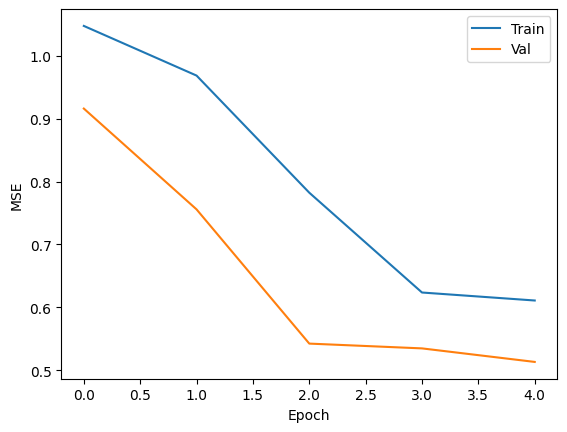

Epoch: 05 
	Train Loss: 0.611 
	 Val. Loss: 0.513 

Epoch: 04 
	Train Loss: 0.624 
	 Val. Loss: 0.535 

Epoch: 03 
	Train Loss: 0.782 
	 Val. Loss: 0.542 

Epoch: 02 
	Train Loss: 0.969 
	 Val. Loss: 0.756 

Epoch: 01 
	Train Loss: 1.048 
	 Val. Loss: 0.916 


After choosing the best model:
Test Loss: 1.172
asdasdas 4
(11707, 1, 10) (11707, 1, 10)


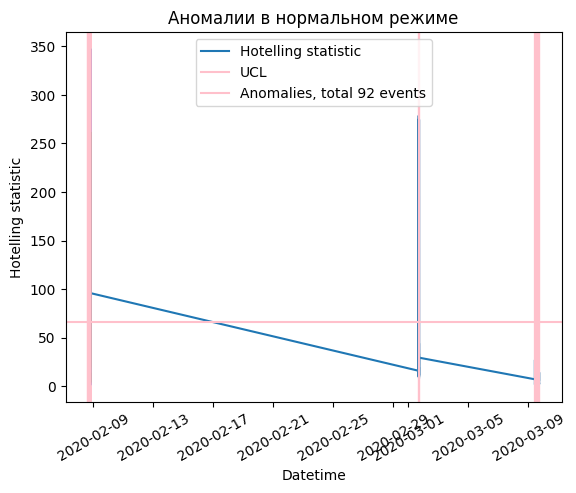

CPU times: user 14.9 s, sys: 16.8 s, total: 31.6 s
Wall time: 12.5 s


In [16]:
%%time
fit_pipeline = Pipeline([
    HighLevelDatasetAnalysisTask(),
    TimeDiscretizationTask(freq_tobe_approach='custom',FREQ_TOBE='1s'),# freq_tobe='1s'),
    FindNaNTask(),
    EquipmentDowntimeTask(),
    ResampleProcessingTask(),
    StandardScalerTask(),
    FeatureProcessingTask(),
    SplitByNaNTask(),
    PrepareSeqSamplesTask(len_seq=10),
    ResidualAnomalyDetectionTask(),
], show=False)
train = fit_pipeline.fit(train_raw,n_epochs=7)

# df

# Проверка аргументов

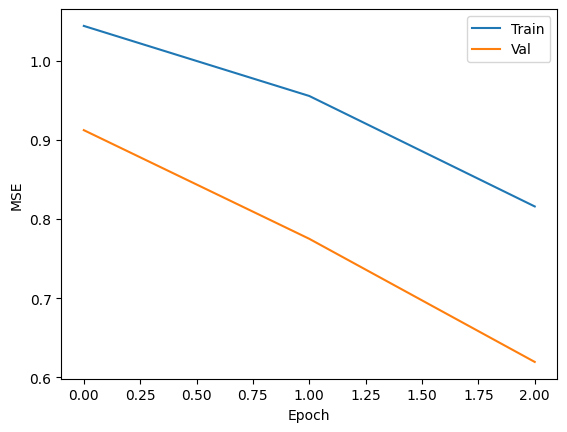

Epoch: 03 
	Train Loss: 0.816 
	 Val. Loss: 0.620 

Epoch: 02 
	Train Loss: 0.955 
	 Val. Loss: 0.775 

Epoch: 01 
	Train Loss: 1.044 
	 Val. Loss: 0.912 


After choosing the best model:
Test Loss: 1.168
asdasdas 4
(11707, 1, 10) (11707, 1, 10)


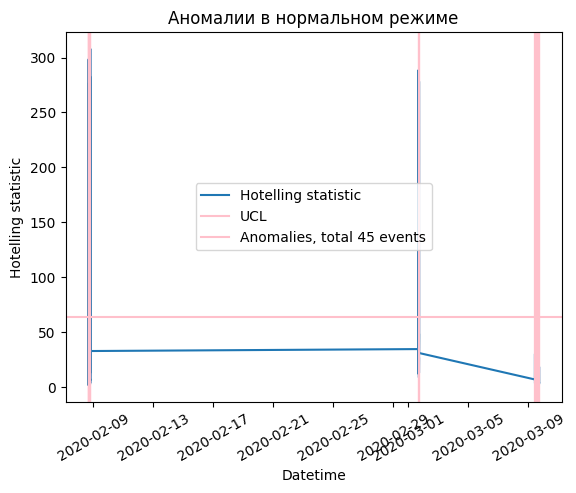

CPU times: user 9.89 s, sys: 13.2 s, total: 23.1 s
Wall time: 8.87 s


(                     0
 0  2020-02-08 16:43:08
 1  2020-02-08 16:44:10
 2  2020-02-08 17:03:14
 3  2020-02-08 17:24:14
 4  2020-02-08 17:37:18
 5  2020-02-08 17:43:19
 6  2020-02-08 17:57:44
 7  2020-02-08 17:58:38
 8  2020-02-08 18:08:03
 9  2020-02-08 18:28:37
 10 2020-02-08 18:57:29
 11 2020-02-08 18:57:33
 12 2020-02-08 19:26:37
 13 2020-02-08 19:31:46
 14 2020-03-01 16:34:52
 15 2020-03-01 16:39:52
 16 2020-03-01 16:54:53
 17 2020-03-01 17:13:53
 18 2020-03-09 10:44:33
 19 2020-03-09 10:50:33
 20 2020-03-09 10:51:34
 21 2020-03-09 11:31:36
 22 2020-03-09 11:45:36
 23 2020-03-09 11:50:36
 24 2020-03-09 12:04:36
 25 2020-03-09 12:05:36
 26 2020-03-09 12:24:36
 27 2020-03-09 12:25:36
 28 2020-03-09 12:44:37
 29 2020-03-09 12:50:37
 30 2020-03-09 12:51:38
 31 2020-03-09 13:04:38
 32 2020-03-09 13:10:38
 33 2020-03-09 13:24:38
 34 2020-03-09 13:31:39
 35 2020-03-09 13:50:39
 36 2020-03-09 14:05:40
 37 2020-03-09 14:25:40
 38 2020-03-09 14:30:40
 39 2020-03-09 14:44:41
 40 2020-03-09 1

In [20]:
%%time
fit_pipeline = Pipeline([
    HighLevelDatasetAnalysisTask(),
    TimeDiscretizationTask(freq_tobe_approach='custom',FREQ_TOBE='1s'),# freq_tobe='1s'),
    FindNaNTask(),
    EquipmentDowntimeTask(),
    ResampleProcessingTask(),
    StandardScalerTask(),
    FeatureProcessingTask(),
    SplitByNaNTask(),
    PrepareSeqSamplesTask(len_seq=10),
#     ResidualAnomalyDetectionTask(),
], show=False)
train = fit_pipeline.fit(train_raw,n_epochs=7)


task = ResidualAnomalyDetectionTask()
task.fit(df=train,result_base_eda=fit_pipeline.results[0],n_epochs=3)

In [7]:
task = PrepareSeqSamplesTask(len_seq=10)
(X_train, _, y_train, _) , _ = task.fit(train)

task = PrepareSeqSamplesTask(len_seq=10)
(_, X_test, _, y_test), _ = task.fit(test)

dfs = [X_train,X_test,y_train,y_test]

Пропущено 102 датастов, из-за того что saples слишком малов в датасете. (len_seq + points_ahead + gap -1 <= len(df))
Пропущено 5 датастов, из-за того что saples слишком малов в датасете. (len_seq + points_ahead + gap -1 <= len(df))


In [8]:
task = ResidualAnomalyDetectionTask()

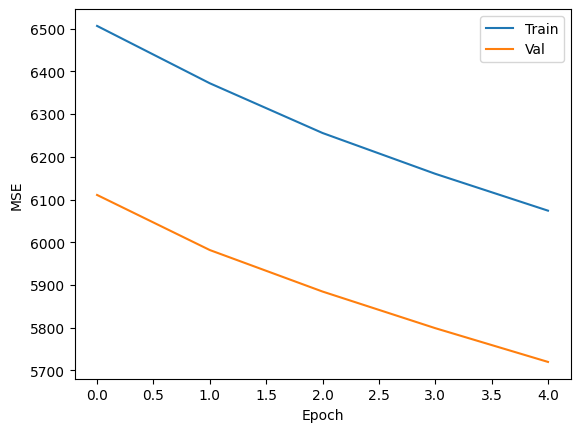

Epoch: 05 
	Train Loss: 6073.866 
	 Val. Loss: 5719.727 

Epoch: 04 
	Train Loss: 6160.178 
	 Val. Loss: 5798.749 

Epoch: 03 
	Train Loss: 6255.710 
	 Val. Loss: 5884.492 

Epoch: 02 
	Train Loss: 6372.125 
	 Val. Loss: 5981.666 

Epoch: 01 
	Train Loss: 6506.401 
	 Val. Loss: 6110.657 


After choosing the best model:
Test Loss: 5760.098
asdasdas 4
(11707, 1, 10) (11707, 1, 10)


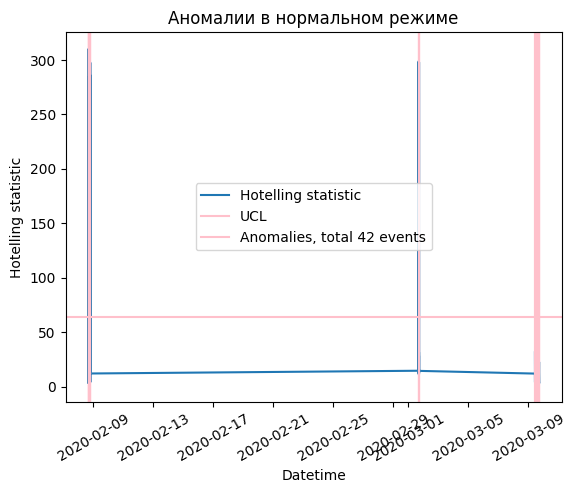

(                     0
 0  2020-02-08 16:39:00
 1  2020-02-08 16:43:08
 2  2020-02-08 16:44:10
 3  2020-02-08 17:03:14
 4  2020-02-08 17:24:14
 5  2020-02-08 17:44:19
 6  2020-02-08 17:58:38
 7  2020-02-08 18:08:03
 8  2020-02-08 18:28:37
 9  2020-02-08 18:57:29
 10 2020-02-08 18:57:33
 11 2020-02-08 19:26:37
 12 2020-02-08 19:31:46
 13 2020-03-01 16:34:52
 14 2020-03-01 16:39:52
 15 2020-03-01 16:54:53
 16 2020-03-01 17:13:53
 17 2020-03-09 10:50:33
 18 2020-03-09 10:51:34
 19 2020-03-09 11:31:36
 20 2020-03-09 11:50:36
 21 2020-03-09 12:04:36
 22 2020-03-09 12:05:36
 23 2020-03-09 12:24:36
 24 2020-03-09 12:25:36
 25 2020-03-09 12:44:37
 26 2020-03-09 12:50:37
 27 2020-03-09 12:51:38
 28 2020-03-09 13:04:38
 29 2020-03-09 13:10:38
 30 2020-03-09 13:24:38
 31 2020-03-09 13:31:39
 32 2020-03-09 14:05:40
 33 2020-03-09 14:25:40
 34 2020-03-09 14:44:41
 35 2020-03-09 14:51:41
 36 2020-03-09 15:24:41
 37 2020-03-09 15:31:42
 38 2020-03-09 16:26:30
 39 2020-03-09 16:27:30
 40 2020-03-09 1

In [9]:
task.fit(dfs,result_base_eda=fit_pipeline.results[0])

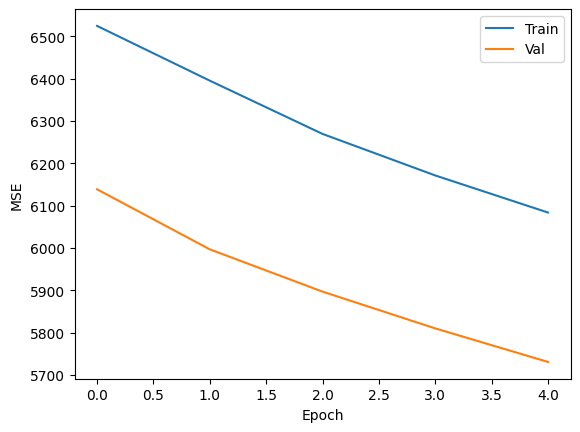

Epoch: 05 
	Train Loss: 6083.952 
	 Val. Loss: 5730.907 

Epoch: 04 
	Train Loss: 6171.584 
	 Val. Loss: 5810.141 

Epoch: 03 
	Train Loss: 6269.739 
	 Val. Loss: 5897.078 

Epoch: 02 
	Train Loss: 6395.580 
	 Val. Loss: 5996.958 

Epoch: 01 
	Train Loss: 6524.946 
	 Val. Loss: 6138.861 


After choosing the best model:
Test Loss: 5770.700


(array([[[ 2.2136703e-02,  2.9314447e-02,  1.3195853e+00, ...,
           4.7365880e+00,  3.5467136e-01, -2.6919544e-03]],
 
        [[ 2.2274986e-02,  2.9329915e-02,  1.3263899e+00, ...,
           4.7632117e+00,  3.5524094e-01, -4.2403638e-03]],
 
        [[ 2.2291049e-02,  2.9312436e-02,  1.3273928e+00, ...,
           4.7671247e+00,  3.5530466e-01, -4.4439733e-03]],
 
        ...,
 
        [[ 2.2292078e-02,  2.9302377e-02,  1.3275695e+00, ...,
           4.7678089e+00,  3.5530967e-01, -4.4724047e-03]],
 
        [[ 2.2292078e-02,  2.9302198e-02,  1.3275702e+00, ...,
           4.7678118e+00,  3.5530955e-01, -4.4724047e-03]],
 
        [[ 2.2292078e-02,  2.9302198e-02,  1.3275702e+00, ...,
           4.7678127e+00,  3.5530955e-01, -4.4724047e-03]]], dtype=float32),
 <tsad.tasks.deep_learning_forecasting.DeepLeaningTimeSeriesForecastingResult at 0x13873ed70>)

In [10]:
task = DeepLeaningTimeSeriesForecastingTask()
task.fit(dfs,result_base_eda=fit_pipeline.results[0])